# Descriptive Analytics

## Data Overview

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from h3 import h3 
from shapely.geometry import shape
from shapely.geometry import Point

In [2]:
df=pd.read_csv('taxi_2017_complete_preprocessed.csv', parse_dates=["start_time","end_time"])
df=df.drop('Unnamed: 0',axis=1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160236 entries, 0 to 5160235
Data columns (total 30 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   start_time                 datetime64[ns]
 1   end_time                   datetime64[ns]
 2   trip_seconds               float64       
 3   trip_miles                 float64       
 4   start_census               int64         
 5   end_census                 int64         
 6   start_community            int64         
 7   end_community              int64         
 8   fare                       float64       
 9   tips                       float64       
 10  tolls                      float64       
 11  extras                     float64       
 12  Trip Total                 float64       
 13  payment_type               object        
 14  company                    object        
 15  start_latitude             float64       
 16  start_longitude            float64  

In [4]:
df.head(3)

,start_time,end_time,trip_seconds,trip_miles,start_census,end_census,start_community,end_community,fare,tips,...,Dropoff Centroid Location,new_TaxiID,dur_min,date,weekday,avg_temp,precip,hour,day,month
0,2017-05-12 21:00:00,2017-05-12 21:15:00,865.0,4.6,17031320100,17031070300,32,7,15.00,2.55,...,POINT (-87.6513108767 41.9290469366),2464,14.42,2017-05-12 00:00:00,4,21.1,0.0,21,12,5
1,2017-04-27 11:30:00,2017-04-27 11:30:00,20.0,0.0,17031210601,17031210601,21,21,3.25,0.65,...,POINT (-87.7112105933 41.93866619620001),4463,0.33,2017-04-27 00:00:00,3,14.4,1.0,11,27,4
2,2017-06-29 01:00:00,2017-06-29 01:15:00,1560.0,17.1,17031980000,17031081000,76,8,33.65,0.00,...,POINT (-87.6333080367 41.899602111),3884,26.00,2017-06-29 00:00:00,3,25.6,0.0,1,29,6


In [5]:
df.tail(3)

,start_time,end_time,trip_seconds,trip_miles,start_census,end_census,start_community,end_community,fare,tips,...,Dropoff Centroid Location,new_TaxiID,dur_min,date,weekday,avg_temp,precip,hour,day,month
5160233,2017-10-23 11:15:00,2017-10-23 11:15:00,360.0,0.0,17031071100,17031062200,7,6,6.00,3.00,...,POINT (-87.6559981815 41.9442266014),2906,6.0,2017-10-23 00:00:00,0,10.6,1.0,11,23,10
5160234,2017-10-07 13:45:00,2017-10-07 14:00:00,900.0,3.1,17031081500,17031081800,8,8,12.25,2.65,...,POINT (-87.6378442095 41.8932163595),4986,15.0,2017-10-07 00:00:00,5,20.0,0.0,13,7,10
5160235,2017-10-23 22:30:00,2017-10-23 22:45:00,900.0,3.9,17031320400,17031242200,32,24,13.75,2.00,...,POINT (-87.6763559892 41.90120699410001),401,15.0,2017-10-23 00:00:00,0,11.7,0.0,22,23,10


In [6]:
df.count()

start_time                   5160236
end_time                     5160236
trip_seconds                 5160236
trip_miles                   5160236
start_census                 5160236
end_census                   5160236
start_community              5160236
end_community                5160236
fare                         5160236
tips                         5160236
tolls                        5160236
extras                       5160236
Trip Total                   5160236
payment_type                 5160236
company                      5160236
start_latitude               5160236
start_longitude              5160236
Pickup Centroid Location     5160236
end_latitude                 5160236
end_longitude                5160236
Dropoff Centroid Location    5160236
new_TaxiID                   5160236
dur_min                      5160236
date                         5160236
weekday                      5160236
avg_temp                     5160236
precip                       5160236
h

## Temporal Demand Patterns

### Usage During a Day

In [7]:
# number of trips for every hour on a day
trips_day = np.zeros(24)
for i in range(24):
    trips_day[i] = len(df[df['hour']==i])
    
time = pd.DataFrame({'Time_Period': range(24), 'Trips': trips_day})
time.head()

,Time_Period,Trips
0,0,175805.0
1,1,136084.0
2,2,111422.0
3,3,87666.0
4,4,61557.0


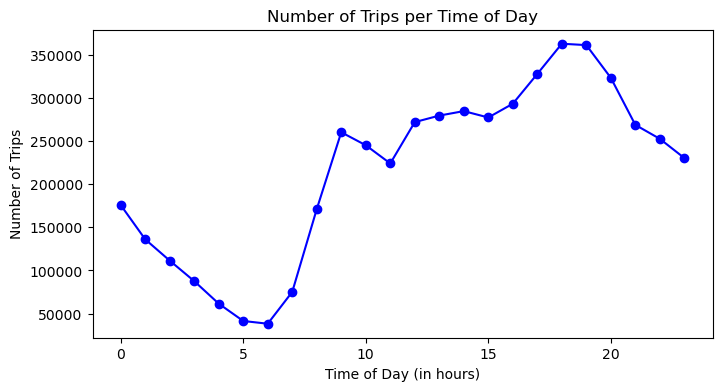

In [8]:
# hourly demand
plt.figure(figsize=(8,4))
plt.plot(time['Time_Period'],time['Trips'],'o-', color='blue')
plt.xlabel("Time of Day (in hours)")
plt.ylabel("Number of Trips")
plt.title("Number of Trips per Time of Day")
#plt.savefig("daily demand.png")
plt.show()

### Usage during a Week

In [9]:
weekdays =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_week=np.zeros(7)
for i in range(7):
    trips_week[i] = len(df[df["weekday"]==i])
    
weekdaysize = pd.DataFrame({'Weekday': weekdays, 'Trips': trips_week})
weekdaysize

,Weekday,Trips
0,Monday,664153.0
1,Tuesday,732597.0
2,Wednesday,790077.0
3,Thursday,835216.0
4,Friday,872940.0
5,Saturday,682027.0
6,Sunday,583226.0


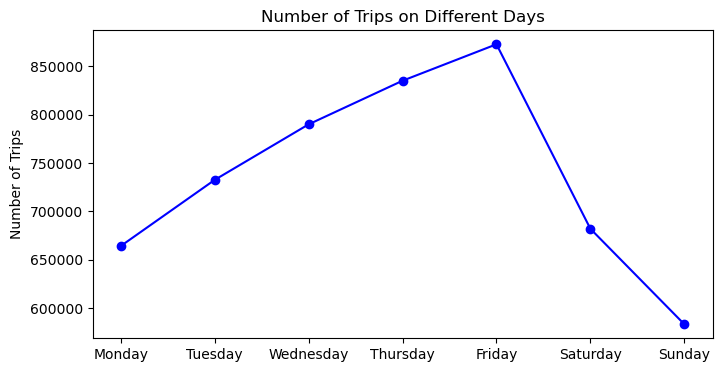

In [10]:
# weekly demand
plt.figure(figsize=(8,4))
plt.plot(weekdaysize["Weekday"], weekdaysize["Trips"],'o-', color='blue')
plt.ylabel("Number of Trips")
plt.title("Number of Trips on Different Days")
#plt.savefig("weekly demand.png")
plt.show()

In [11]:
# Warum so wenige Samstag und Sonntag?

### Usage during a Year

In [12]:
months=["January","February","March","April","May","June","July","August","September","Oktober","November","December"]

In [13]:
trips_month = np.zeros(12)
for i in range(12):
    trips_month[i]= len(df[df["month"]==i+1])

year= pd.DataFrame({'Months':months, 'Trips':trips_month})
year

,Months,Trips
0,January,487208.0
1,February,478250.0
2,March,605543.0
3,April,559797.0
4,May,596580.0
5,June,594884.0
6,July,505701.0
7,August,499759.0
8,September,473807.0
9,Oktober,354867.0


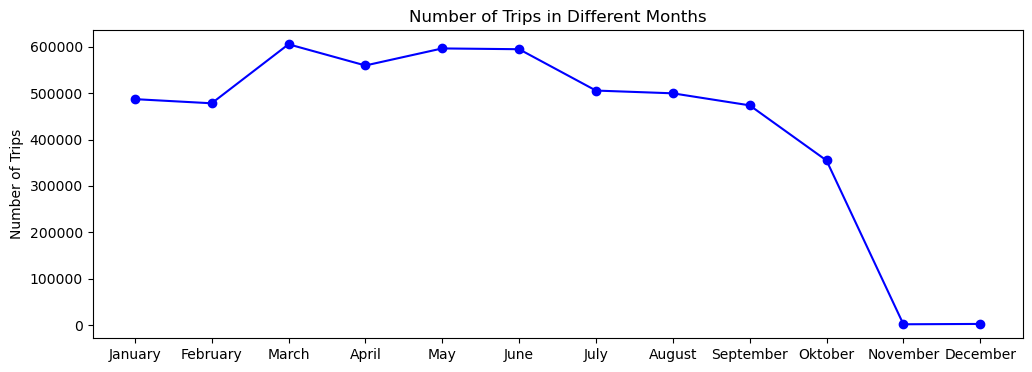

In [14]:
# yearly demand
plt.figure(figsize=(12,4))
plt.plot(year["Months"], year["Trips"],'o-', color='blue')
plt.ylabel("Number of Trips")
plt.title("Number of Trips in Different Months")
#plt.savefig("yearly demand.png")
plt.show()

In [15]:
# Warum so wenige im November und Dezember?

In [16]:
# Seasonal Comparison??

## Spatial Analysis

### Load Data and Data Overview

In [17]:
H3_HEXAGON_RESOLUTION = 8

In [18]:
df["h3_hex_id_start"] = df.apply(lambda row: h3.geo_to_h3(row["start_latitude"], row["start_longitude"], H3_HEXAGON_RESOLUTION) if (row['start_latitude'] and row['start_longitude']) else 0, axis=1)
# df["h3_hex_id_end"] = df.apply(lambda row: h3.geo_to_h3(row["end_latitude"], row["end_longitude"], H3_HEXAGON_RESOLUTION) if (row['end_latitude'] and row['end_longitude']) else 0, axis=1)

#### Taxi Trip Dataset

In [19]:
# df['start_time'] = pd.to_datetime(df['start_time'])

In [20]:
# Convert taxi_trips DataFrame to a GeoDataFrame
taxi_trips = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.start_longitude, df.start_latitude)
)
taxi_trips.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5160236 entries, 0 to 5160235
Data columns (total 32 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   start_time                 datetime64[ns]
 1   end_time                   datetime64[ns]
 2   trip_seconds               float64       
 3   trip_miles                 float64       
 4   start_census               int64         
 5   end_census                 int64         
 6   start_community            int64         
 7   end_community              int64         
 8   fare                       float64       
 9   tips                       float64       
 10  tolls                      float64       
 11  extras                     float64       
 12  Trip Total                 float64       
 13  payment_type               object        
 14  company                    object        
 15  start_latitude             float64       
 16  start_longitude            f

#### Census Dataset

In [21]:
# census data from "extra files" for census bounderies
census=gpd.read_file('extra_dataframes/Census Tracts - 2010.geojson')
census.head(2)

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ..."
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ..."


<Axes: >

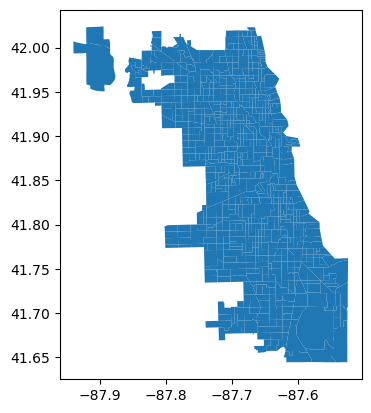

In [22]:
# Plot Census Tracts of Chicago
census.plot()

In [23]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   statefp10   801 non-null    object  
 1   name10      801 non-null    object  
 2   commarea_n  801 non-null    object  
 3   namelsad10  801 non-null    object  
 4   commarea    801 non-null    object  
 5   geoid10     801 non-null    object  
 6   notes       801 non-null    object  
 7   tractce10   801 non-null    object  
 8   countyfp10  801 non-null    object  
 9   geometry    801 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 62.7+ KB


#### New Dataframe for Census Analysis

In [24]:
census_analysis = census[['geoid10','geometry']]
census_analysis = census_analysis.rename(columns={'geoid10':'start_census'})
census_analysis['start_census'] = census_analysis['start_census'].astype('int64')
census_analysis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   start_census  801 non-null    int64   
 1   geometry      801 non-null    geometry
dtypes: geometry(1), int64(1)
memory usage: 12.6 KB


In [25]:
# Merge the taxi trips data with the census tract boundaries based on spatial intersection
#taxi_trips_tracts = gpd.sjoin(taxi_trips, census[['geoid10','geometry']], how = 'left', op='within')

In [26]:
#taxi_trips_tracts.count()

In [27]:
#taxi_trips_tracts.head()

In [28]:
#trips_starts_geo.plot(column='count', cmap='Reds')

#### New Dataframe for Hexagon Analysis

In [29]:
import json
city_bounding_box = gpd.read_file('extra_dataframes/Boundaries - City.geojson')
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

In [30]:
city_bounding_box_poly

{'id': '0',
 'type': 'Feature',
 'properties': {'name': 'CHICAGO',
  'objectid': '1',
  'shape_area': '6450276623.31',
  'shape_len': '845282.931362'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-87.93514385942143, 42.00088911607326],
     [-87.9352110270025, 42.00081664143955],
     [-87.93529133950187, 42.00072700895027],
     [-87.93551196383594, 42.000480781935586],
     [-87.93574247939097, 42.00025812301311],
     [-87.93584505940073, 42.000159039381906],
     [-87.93590356821541, 42.00010497538239],
     [-87.93598608216818, 42.00001374987231],
     [-87.93632784066214, 41.99960326946243],
     [-87.9366154497264, 41.99923337944194],
     [-87.93677128867272, 41.999023248278675],
     [-87.9368759749499, 41.998881847153044],
     [-87.93693408810181, 41.99880335510703],
     [-87.93706164890665, 41.998612362462175],
     [-87.93707950926456, 41.998585741964575],
     [-87.93905445886887, 41.99826104013864],
     [-87.93982896518334, 41.99813745944146],
     [-87.

<Axes: >

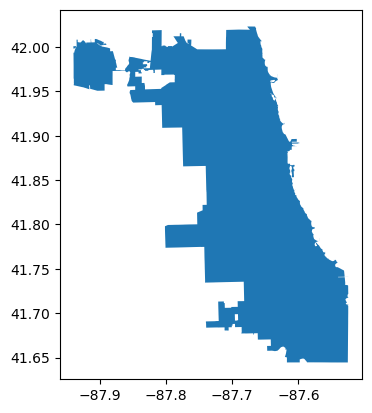

In [31]:
city_bounding_box.plot()

In [65]:
# Computing hexagons for a chicago
H3_HEXAGON_RESOLUTION = 6
polygon_obj = city_bounding_box_poly["geometry"]
#hexagons = []
#for index, row in polygon_obj['coordinates'].iterrows():
 # hexagons.extend(h3.polyfill(row['geometry'].__geo_interface__, h3resolution, geo_json_conformant=True))
#hexagons = h3.polyfill(polygon_obj, res = H3_HEXAGON_RESOLUTION, geo_json_conformant = True)

### Start Time Variation

In [33]:
# Convert the 'start_time' column to Unix timestamps
# taxi_trips_tracts['start_time'] = (taxi_trips_tracts['start_time'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(seconds=1)

In [34]:
# Calculate the average start time for each census tract
#tract_avg_start_time = taxi_trips_tracts.groupby('geoid10')['start_time'].mean()
#tract_avg_start_time.info()

In [35]:
# Merge the average start time data with the census tract boundaries
#census_avg_start_time = census.merge(tract_avg_start_time, left_on='geoid10', right_index=True)

In [36]:
#import matplotlib.dates as mdates

# Create the plot
#fig, ax = plt.subplots(figsize=(10, 10))
#census_avg_start_time.plot(column='start_time', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Format the legend to display datetime values
#legend = ax.get_legend()
#if legend:
#    date_format = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
#    legend.set_title('Average Start Time')
#    legend.set_bbox_to_anchor((1.2, 1))
#    legend.set_frame_on(False)
#    legend.set_yticklabels([date_format(x) for x in legend.get_yticks()])
#
#ax.set_title('Average Start Time by Census Tract')
#plt.show()

### Trip Length Variation

In [37]:
trip_length = taxi_trips.groupby('start_census')['trip_miles'].mean()
trip_length = pd.DataFrame(trip_length)
trip_length = trip_length.reset_index()
#trip_length['start_census'] = trip_length['start_census'].astype(object)
trip_length.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   start_census  378 non-null    int64  
 1   trip_miles    378 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.0 KB


In [38]:
a =census_analysis.merge(trip_length, how = 'left', on='start_census')
#(a['start_census'].unique()).shape
census_analysis['trip_length'] = a['trip_miles']
census_analysis.head(3)

,start_census,geometry,trip_length
0,17031842400,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ...",NaN
1,17031840300,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ...",0.438366
2,17031841100,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ...",2.018864


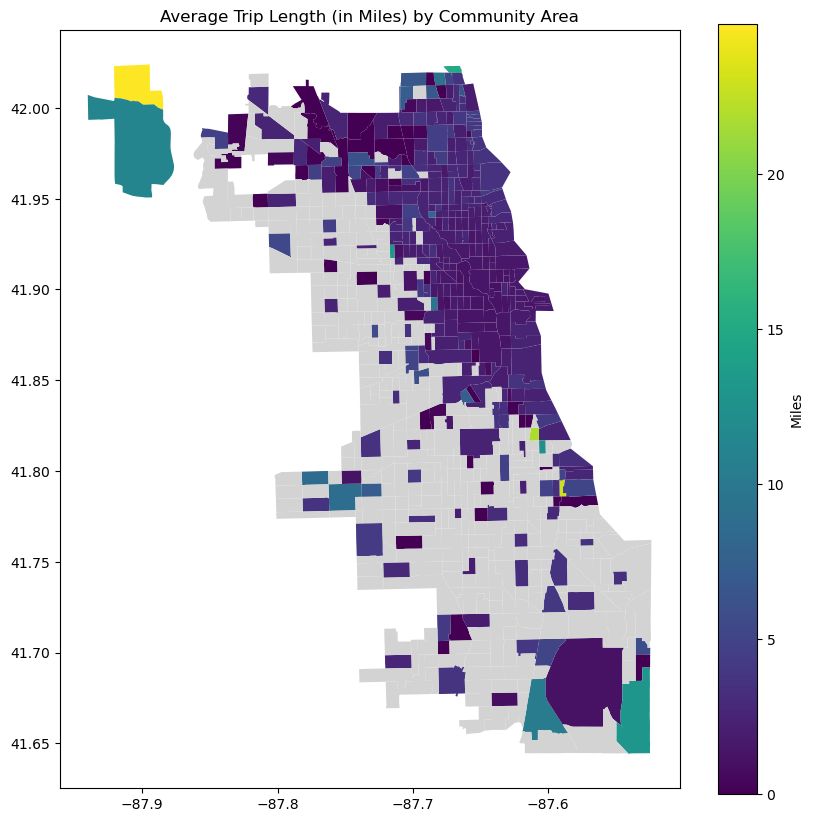

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
census_analysis.plot(column='trip_length', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Miles"}, missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Trip Length (in Miles) by Community Area')
plt.show()

In [40]:
# Calculate the average trip length for each census tract
#tract_avg_trip_length = taxi_trips_tracts.groupby('geoid10')['trip_miles'].mean()
#tract_avg_trip_length = taxi_trips.groupby('start_census')['trip_miles'].mean()
#tract_avg_trip_length.info()

In [41]:
#tract_avg_trip_length.head()

In [42]:
#census.rename(columns={"geoid10": "census_start"})

In [43]:
# Merge the average trip length data with the census tract bounderies
#census_avg_trip_length = census.merge(tract_avg_trip_length, left_on='geoid10', right_index=True)
#census_avg_trip_length = census.merge(tract_avg_trip_length, on='census_start')
#census_avg_trip_length.head()

In [44]:
# Create the plot
#fig, ax = plt.subplots(figsize=(10, 10))
#census_avg_trip_length.plot(column='trip_miles', cmap='viridis', linewidth=0.8, ax=ax, legend=True, legend_kwds={'label': "Average Trip Length by Start Census Tract"}, missing_kwds={'color': 'lightgrey'})
#ax.set_title('Average Trip Length by Community Area')
#plt.show()

In [45]:
# Calculate the average trip length for each census tract
#tract_trip_length = taxi_trips.groupby('start_census')['trip_miles'].mean()
#tract_trip_length.info()  # -> es gibt viele census tracts ohne trip start

In [46]:
#tract_trip_length.head() 

In [47]:
#tract_trip_length_df = pd.DataFrame(tract_trip_length)

In [48]:
#tract_trip_length_df.head()

In [49]:
# Merge the average trip length data with the census tract bounderies
#census_trip_length = census.merge(tract_trip_length, left_on='geoid10', right_index=True)

In [50]:
trips_starts = pd.DataFrame()
trips_starts = df.groupby('h3_hex_id_start').mean()['trip_miles'].reset_index().rename(columns={'trip_miles': 'mean_trip_miles'})
trips_starts['geometry'] = trips_starts.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_hex_id_start"], geo_json=True)), axis=1)

trips_starts_geo = gpd.GeoDataFrame(trips_starts, geometry=trips_starts['geometry'], crs='EPSG:4326')

C:\Users\Lara\AppData\Local\Temp\ipykernel_1552\4076487419.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trips_starts = df.groupby('h3_hex_id_start').mean()['trip_miles'].reset_index().rename(columns={'trip_miles': 'mean_trip_miles'})


In [51]:
trips_starts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   h3_hex_id_start  267 non-null    object 
 1   mean_trip_miles  267 non-null    float64
 2   geometry         267 non-null    object 
dtypes: float64(1), object(2)
memory usage: 6.4+ KB


<Axes: >

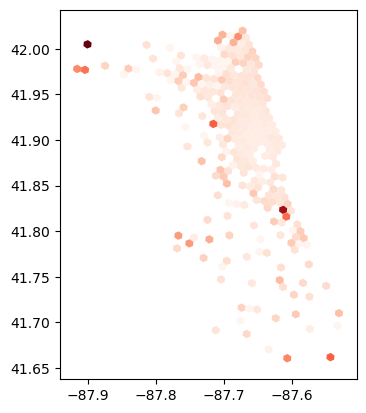

In [52]:
trips_starts_geo.plot(column='mean_trip_miles', cmap='Reds')